In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,scale,StandardScaler,RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from tqdm.notebook import tqdm  # Import tqdm for progress bar
import seaborn as sns
from myMLlib import set_seed, load_feather, rebalance_weight, plt_loss, plt_confusion, layer_activation
from scipy.sparse.linalg import svds
from torch.utils.data import TensorDataset, DataLoader
import yaml

In [2]:
with open('hyperparameters.yml', 'r') as file:
    all_parameters = yaml.safe_load(file)
    parameters = all_parameters['real-blood-meat-time']
materials = parameters['materials']
realmater = parameters['realmater']
materials = list(materials.values())
print(materials)
print(realmater)


['Vessel', 'Tissue']
['Silicone/Water', 'Silicone']


In [3]:
folderpath= ('/home/yuqster/files/research/dataset/realtest1',
             '/home/yuqster/files/research/dataset/realtest2',
             '/home/yuqster/files/research/dataset/realtest3',
             '/home/yuqster/files/research/dataset/realtest4',
             '/home/yuqster/files/research/dataset/realtest5',
             )
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 20,
    'axes.labelsize': 16,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 14
})

In [4]:
data_list,labels = load_feather(folderpath,materials,[5e4 , 5e4, 2e4, 2e4, 2e4])

In [5]:
seed = 43
set_seed(seed)
snapshot = np.array(data_list[0]+data_list[1]+data_list[2]+data_list[3]).squeeze()
y = np.array(labels[0]+ labels[1]+labels[2]+labels[3]).reshape(-1,1)
snapshot_r = np.array(data_list[4]).squeeze()
y_r = np.array(labels[4]).reshape(-1,1)
print(snapshot.shape)
print(y.shape)
print(snapshot_r.shape)
print(y_r.shape)


(140000, 4096)
(140000, 1)
(20000, 4096)
(20000, 1)


In [6]:
snapshot_train, snapshot_test, y_train, y_test = train_test_split(snapshot, y, test_size=0.001, random_state=42)
_,S,Vt = svds(snapshot_train, k=100)
S = S[::-1]
Vt = Vt[::-1,:]

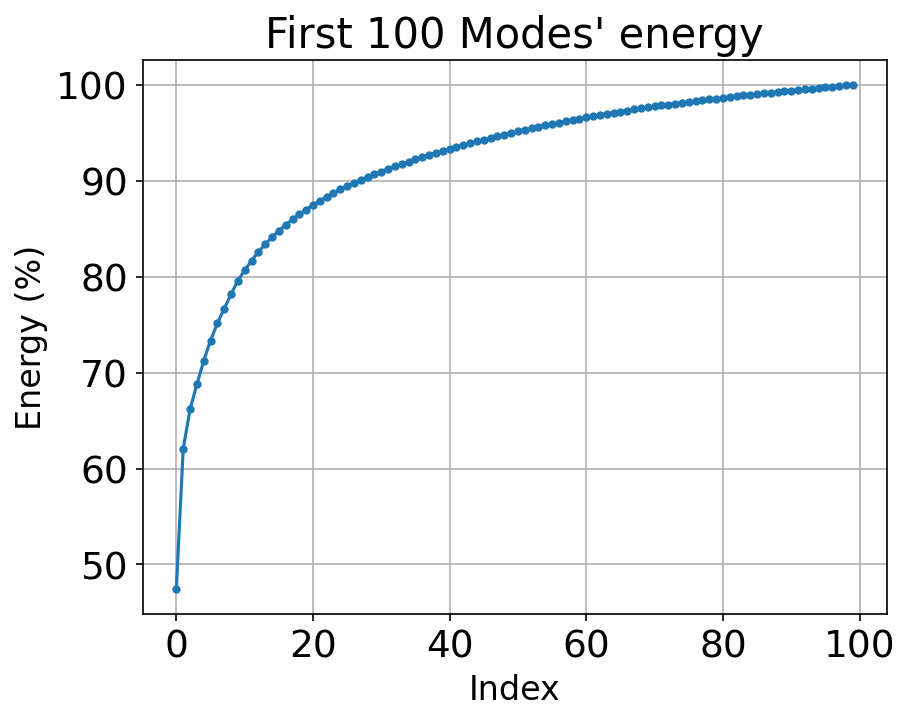

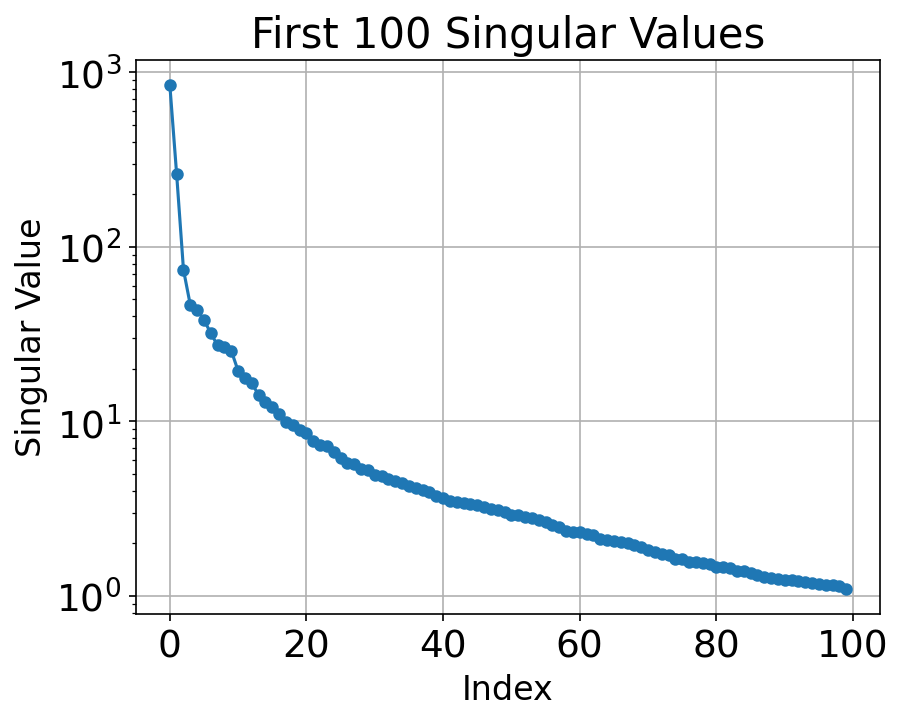

In [22]:
V = Vt.T
energy = np.cumsum(S)/np.sum(S)*100
plt.figure(dpi=150)
plt.plot(energy[0:100],marker = 'o',linestyle='-',markersize = 3)
plt.xlabel('Index')
plt.ylabel('Energy (%)')
plt.grid(True)
plt.title("First 100 Modes' energy")
plt.show
# 假设 S 是从 np.linalg.svd 得到的奇异值数组
plt.figure(dpi=150)
plt.semilogy(S[:100], marker='o', linestyle='-', markersize=5)
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title("First 100 Singular Values")
plt.grid(True)
plt.show()

In [112]:
Vr = V[:,:26]
Xp_train = snapshot_train @ Vr
Xp_test = snapshot_test @ Vr
Xp_r = snapshot_r @ Vr
# joblib.dump(Vr,'/Users/stonyxiong/files/Research/models/bloodmeat_time_Vr.save')

<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_33309/1611112955.py:46: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Time($\mu s$)",fontsize = 20)


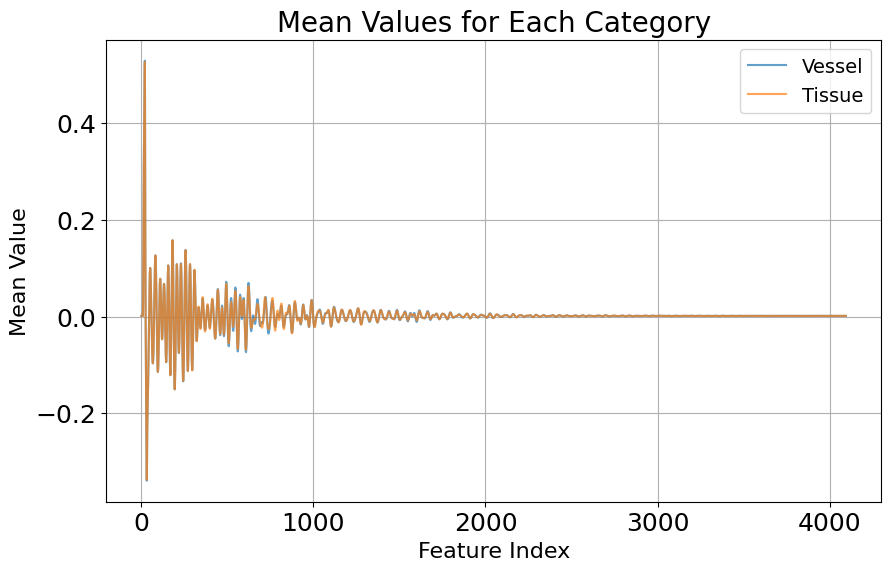

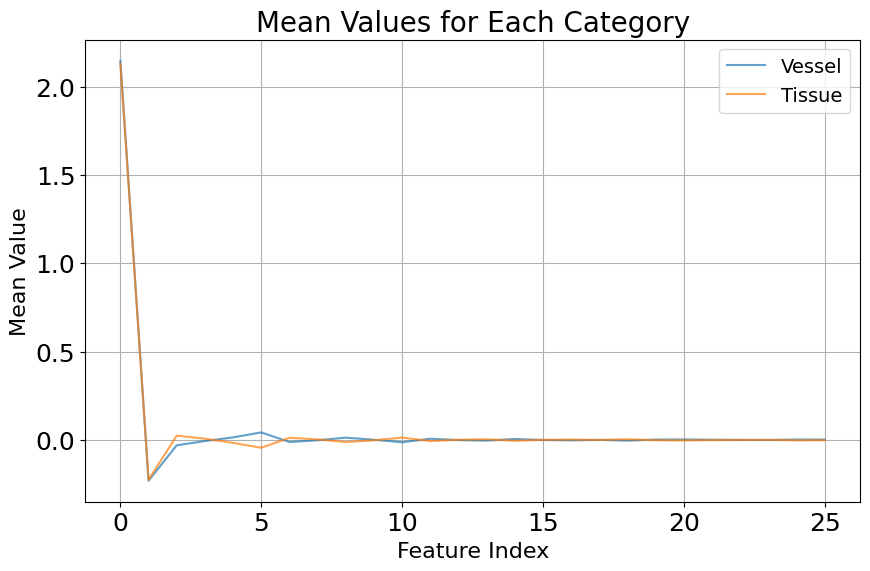

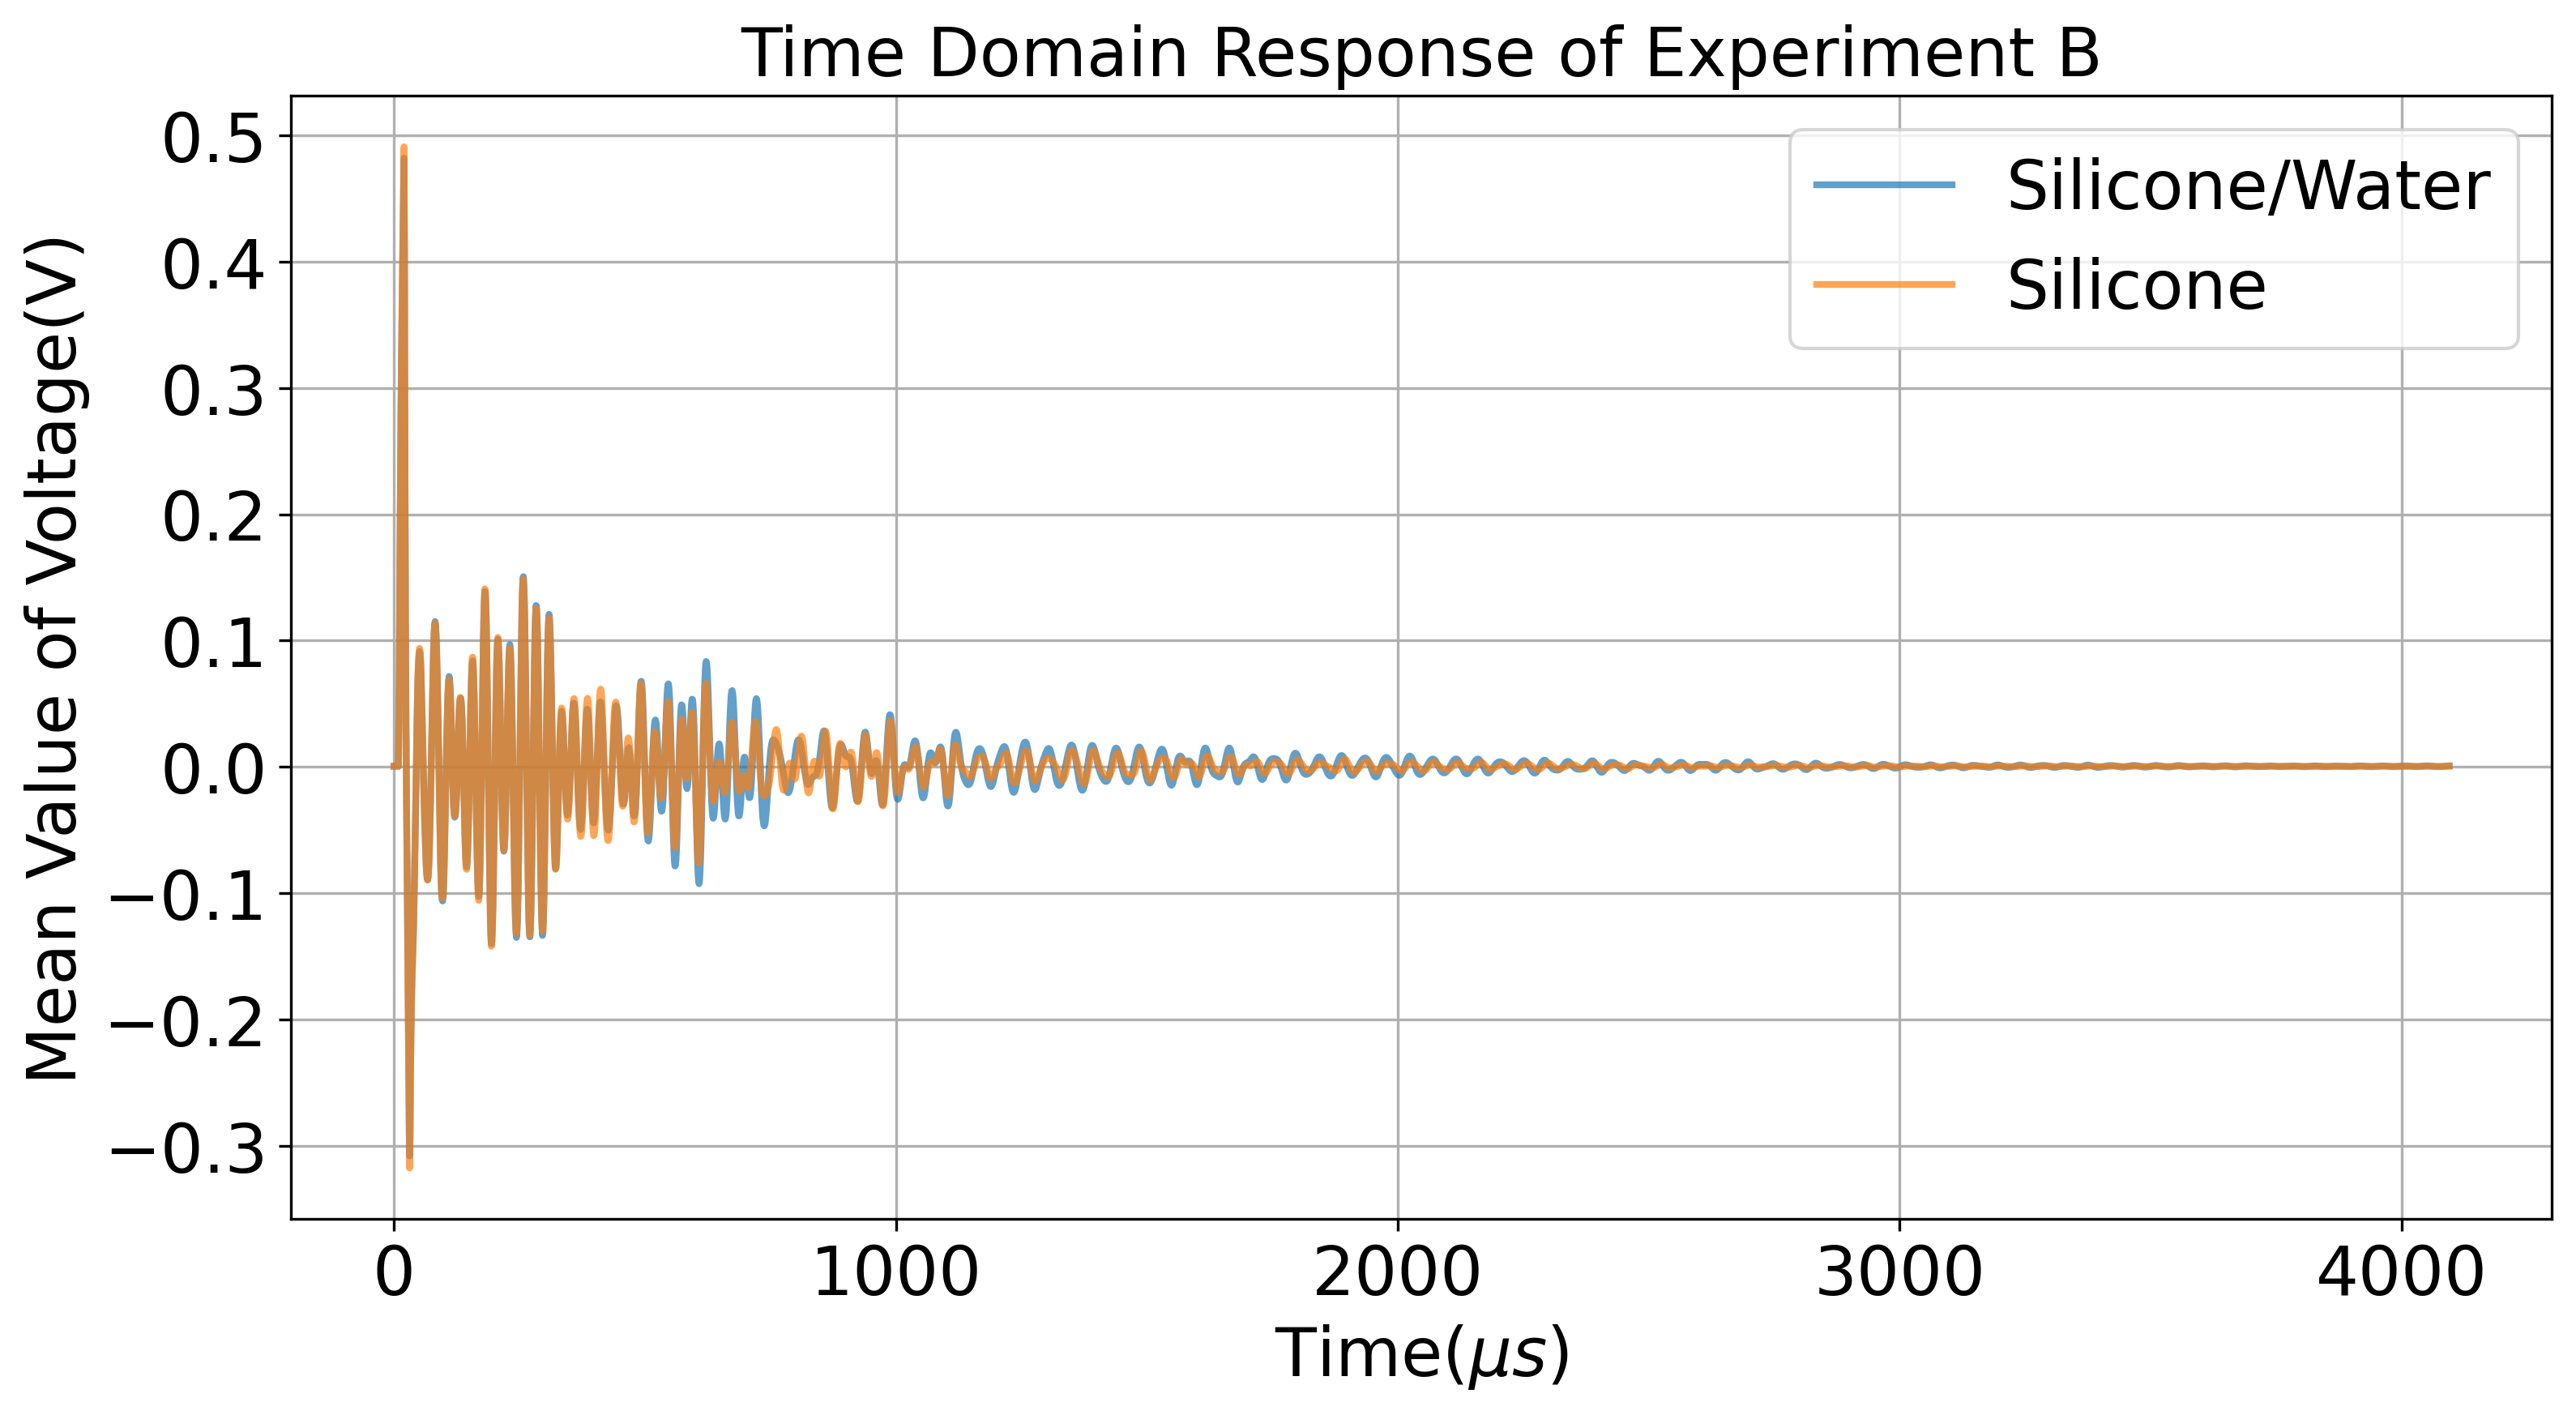

In [113]:
unique_labels = np.unique(y_train)
indices1 = {}
indices2 = {}
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices1[materials[i]] = np.where(y_train.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = snapshot_train[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[i]}",alpha = 0.7)
# for i, value in enumerate(points):
#     if i == 0:
#         plt.axvline(x=value, color='red', linestyle='--', label='points')
#     else:
#         plt.axvline(x=value, color='red', linestyle='--')
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values for Each Category")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices1[materials[i]] = np.where(y_train.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = Xp_train[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[int(label)]}",alpha = 0.7)
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values for Each Category")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6),dpi=300)
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices2[materials[i]] = np.where(y_r.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = snapshot_r[indices2[materials[i]]].mean(axis=0) # type: ignore
        # 绘制均值曲线
    plt.plot(mean_values, label=f"{realmater[i]}",alpha = 0.7, linewidth = 2)
plt.xlabel("Time($\mu s$)",fontsize = 20)
plt.ylabel("Mean Value of Voltage(V)",fontsize = 20)
plt.title("Time Domain Response of Experiment B", fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.grid(True)
# plt.savefig("/Users/stonyxiong/files/Research/figures/ExpBtime-160.pdf", format="pdf", bbox_inches="tight")
plt.show()
# fig, ax1 = plt.subplots(figsize=(8,6), dpi=400)
# ax2 = ax1.twinx()  # 创建一个共享 x 轴的右侧纵坐标
# for i, label in enumerate(unique_labels):
#     # 获取当前类别下的样本索引
#     indices2[materials[i]] = np.where(y_r.flatten() == label)
#     # 计算均值和标准差（按列统计）
#     mean_values = snapshot_r[indices2[materials[i]]].mean(axis=0)  # type: ignore
#     std_vals = snapshot_r[indices2[materials[i]]].std(axis=0)
#     # 在左侧坐标系绘制均值曲线
#     ax1.plot(time_vec*1e6, mean_values, label=f"{realmater[i]}", alpha=0.7, linewidth=2)
#     # 在右侧坐标系绘制标准差曲线
#     ax2.plot(time_vec*1e6, std_vals, label=f"SD of {realmater[i]}", linestyle='--')

# ax1.set_xlabel("Time($\mu s$)")
# ax1.set_ylabel("Mean Value of Voltage(V)")
# ax2.set_ylabel("Standard Deviation(V)")
# ax2.set_ylim([0,0.1])
# # yticks = np.arange(-65, -4, 5)  # 上限为 -4 以确保包含 -5
# # ax1.set_yticks(yticks)
# # ax1.set_ylim([-60,-5])
# ax1.set_title("Time Domain Response of Experiment B", fontsize=20)
# ax1.set_xlim([0, 160])
# ax1.grid(True)

# # 合并左右坐标系中的图例
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=10, loc='best',ncol = 2)
# # plt.savefig("/Users/stonyxiong/files/Research/figures/ExpBtime-160.pdf", format="pdf", bbox_inches="tight")
# plt.show()

In [114]:
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if (hasattr(torch.backends, "mps") and torch.backends.mps.is_available()) 
    else "cpu"
)
print("Using device:", device)

Using device: cuda


In [115]:
# Split data into train and test sets


# X_train = scale(Xp_train,axis=1)
# X_test = scale(Xp_test,axis=1)
# X_r_test = scale(Xp_r,axis=1)
scaler = StandardScaler()
# scaler = RobustScaler(unit_variance=False)
X_train = scaler.fit_transform(Xp_train)
X_test = scaler.transform(Xp_test)
X_r_test = scaler.transform(Xp_r)
# joblib.dump(scaler,'/Users/stonyxiong/files/Research/models/bloodmeat_time_scaler.save')

scaler = MinMaxScaler(feature_range=(0, len(materials)-1))
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_r_test = scaler.transform(y_r)

X_r_ver,X_r_te, y_r_ver, y_r_te = train_test_split(X_r_test, y_r_test, train_size = 0.3,random_state=42)

print(X_r_ver.shape)
print(X_r_te.shape)

(6000, 26)
(14000, 26)


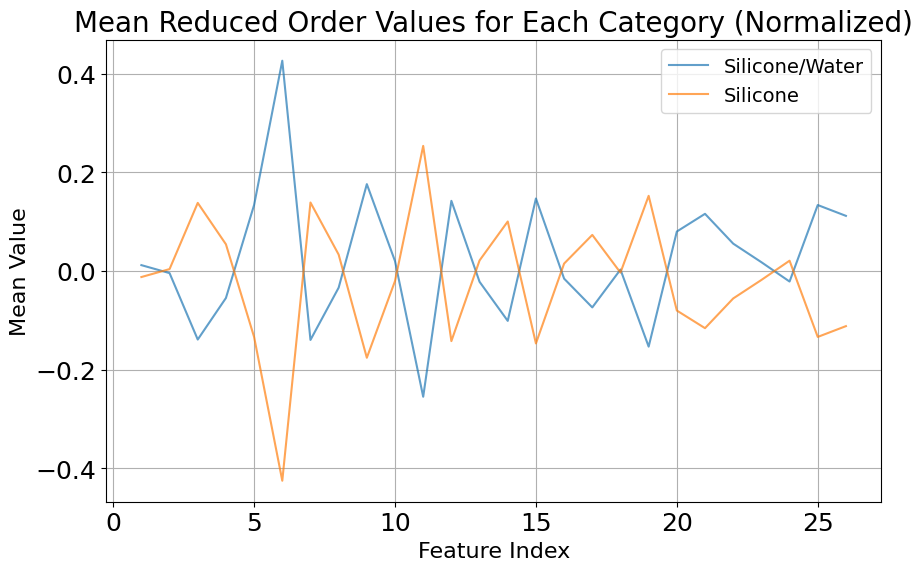

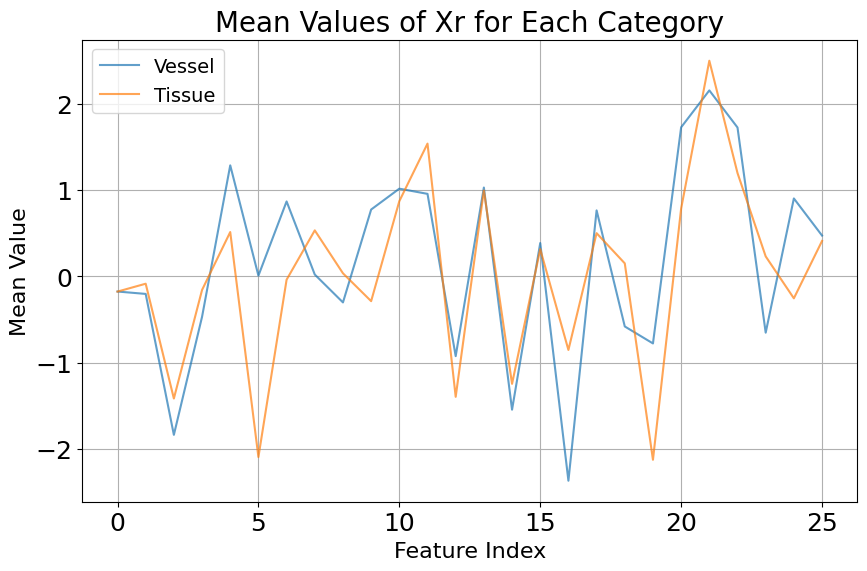

In [116]:
indices1 = {}
indices2 = {}
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices1[materials[i]] = np.where(y_train.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_train[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(range(1, mean_values.shape[0] + 1), mean_values, label=f"{realmater[int(label)]}", alpha=0.7)
plt.xlabel("Feature Index")
# plt.xlim([1,36])
plt.ylabel("Mean Value")
plt.title("Mean Reduced Order Values for Each Category (Normalized)")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices2[materials[i]] = np.where(y_r_te.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_r_te[indices2[materials[i]]].mean(axis=0) # type: ignore
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[i]}",alpha = 0.7)
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values of Xr for Each Category")
plt.legend()
plt.grid(True)
plt.show()



In [127]:
class ANN_Model(nn.Module):
    def __init__(self, inputdim, hid1dim=20, hidmdim=24, p_drop=0.0):
        super().__init__()
        self.fc1 = nn.Linear(inputdim, hid1dim)
        self.fc2 = nn.Linear(hid1dim, hidmdim)
        self.fc3 = nn.Linear(hidmdim, hid1dim)
        self.head = nn.Linear(hid1dim, 2)
        self.act = nn.ELU()
        self.norm = nn.LayerNorm(hid1dim)   # 稳定训练（可选）
        self.drop = nn.Dropout(p_drop)      # 需要时再开

        # 可选：轻微缩小残差块最后一层权重，起步更稳
        with torch.no_grad():
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
            nn.init.xavier_uniform_(self.head.weight)
            self.fc3.weight.mul_(0.1)

    def forward(self, x):
        h1 = self.act(self.fc1(x))          # [B, hid1dim]
        h2 = self.act(self.fc2(h1))         # [B, hidmdim]
        h3 = self.fc3(h2)                   # [B, hid1dim]
        h = self.norm(h1 + h3)              # 残差在同维度相加
        h = self.act(h)
        h = self.drop(h)
        o = self.head(h)                    # [B, 2]
        return o

set_seed(seed)

In [128]:
model = ANN_Model(X_train.shape[1]).to(device)

class_weights,_ = rebalance_weight(y_train)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
# 4. 将 numpy 数据转为 torch 张量并移动到 device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).squeeze().to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).squeeze().to(device)
X_r_ver_tensor = torch.tensor(X_r_ver, dtype=torch.float32).to(device)
y_r_ver_tensor = torch.tensor(y_r_ver,dtype=torch.long).squeeze().to(device)
X_r_te_tensor = torch.tensor(X_r_te, dtype = torch.float32).to(device)
y_r_te_tensor = torch.tensor(y_r_te,dtype=torch.long).squeeze().to(device)

In [129]:
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# verify_dataset = TensorDataset(X_r_ver_tensor, y_r_ver_tensor)

# train_loader  = DataLoader(train_dataset, batch_size=3000, shuffle=True)
# verify_loader = DataLoader(verify_dataset, batch_size=1000, shuffle=False)

# num_epochs = 20000
# train_losses = []
# verify_losses = []

# pbar = tqdm(range(int(num_epochs)), desc="Training", leave=True)

# for epoch in pbar:
#     model.train()
#     for batch_X, batch_y in train_loader:
#         optimizer.zero_grad()
#         outputs = model(batch_X)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         optimizer.step()
#     train_losses.append(loss.item())
#     # —— 2. 验证 —— #
#     model.eval()
#     with torch.no_grad():
#         for batch_X, batch_y in verify_loader:
#             verify_outputs = model(batch_X)
#             verify_loss = criterion(verify_outputs, batch_y)
#         verify_losses.append(verify_loss.item())
#     # —— 3. 更新 tqdm 的显示 —— #
#     pbar.set_postfix(train_loss=loss.item(), verify_loss=verify_loss.item())

# 5. 训练模型
num_epochs = 16607
train_losses = []
verify_losses = []

pbar = tqdm(range(int(num_epochs)), desc="Training", leave=True)
for epoch in pbar:
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    # —— 2. 验证 —— #
    model.eval()
    with torch.no_grad():
        verify_outputs = model(X_r_ver_tensor)
        verify_loss = criterion(verify_outputs, y_r_ver_tensor)
        verify_losses.append(verify_loss.item())
    # —— 3. 更新 tqdm 的显示 —— #
    pbar.set_postfix(train_loss=loss.item(), verify_loss=verify_loss.item())

Training:   0%|          | 0/16607 [00:00<?, ?it/s]

In [130]:
# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    train_outputs = model(X_train_tensor)
    _, predicted = torch.max(test_outputs, 1)
    _, predicted_train = torch.max(train_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    predicted_np_train = predicted_train.cpu().numpy()
    accuracy_train = accuracy_score(y_train,predicted_np_train)
    accuracy = accuracy_score(y_test, predicted_np)
    cm = confusion_matrix(y_test, predicted_np)

Accuracy: 0.9857142857142858
Accuracy_train: 0.9617903617903618
Confusion Matrix:
[[62  1]
 [ 1 76]]


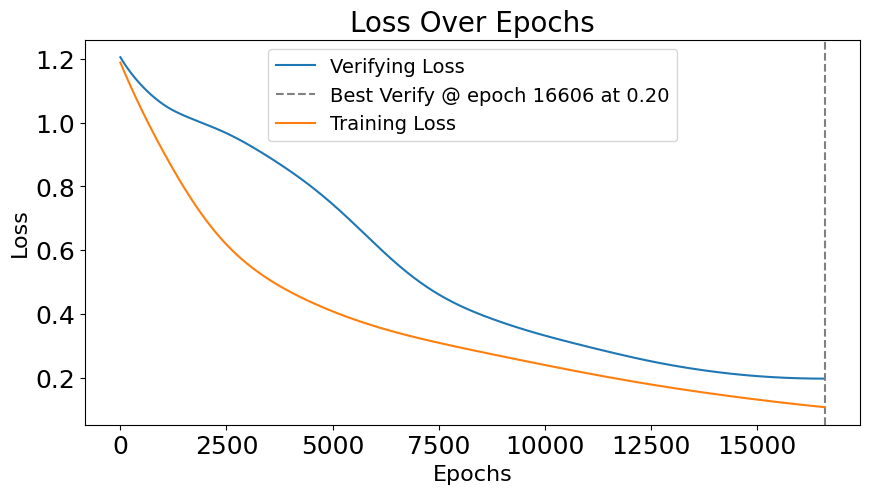

In [131]:
print(f'Accuracy: {accuracy}')
print(f'Accuracy_train: {accuracy_train}')
print(f'Confusion Matrix:\n{cm}')

plt_loss(train_losses=train_losses, verifying_losses =verify_losses)

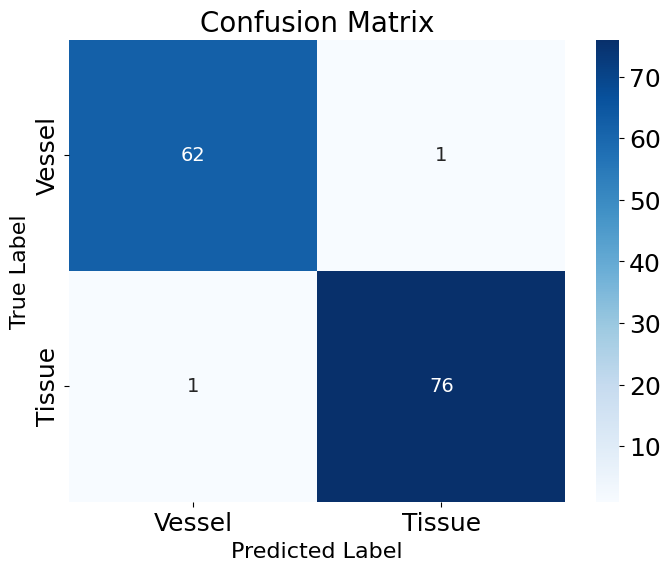

Accuracy: 0.9857142857142858
              precision    recall  f1-score   support

      Vessel       0.98      0.98      0.98        63
      Tissue       0.99      0.99      0.99        77

    accuracy                           0.99       140
   macro avg       0.99      0.99      0.99       140
weighted avg       0.99      0.99      0.99       140



In [132]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=materials,
            yticklabels=materials)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix")
plt.show()

# Convert y_test to integer labels
y_test_int = y_test.astype(int)

# Show classification reportaccuracy
report = classification_report(y_test_int, predicted_np,
                               target_names=materials, labels=range(len(materials)))
print("Accuracy:", accuracy)
print(report)

In [133]:
model.eval()
with torch.no_grad():
    r_ver_outputs = model(X_r_ver_tensor)
    _, predicted = torch.max(r_ver_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    ver_accuracy = accuracy_score(y_r_ver, predicted_np)
    ver_cm = confusion_matrix(y_r_ver, predicted_np)

Accuracy: 0.93


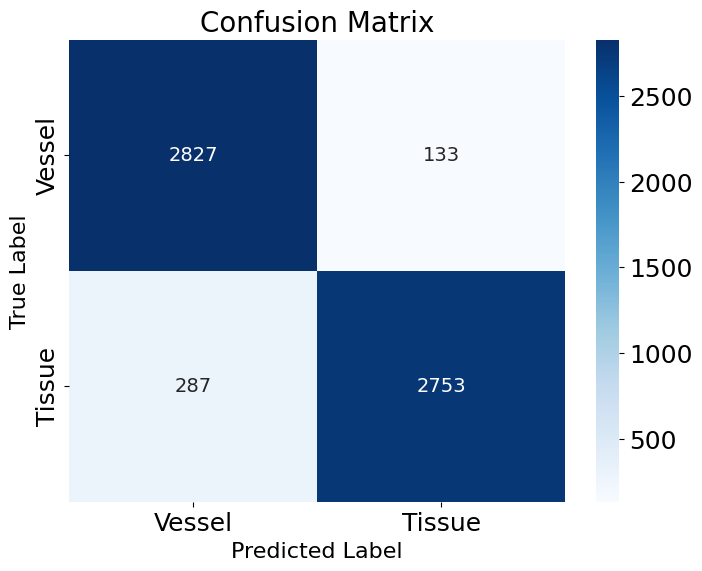

In [134]:
print(f'Accuracy: {ver_accuracy}')
plt_confusion(ver_cm,materials)

In [135]:
model.eval()
with torch.no_grad():
    r_te_outputs = model(X_r_te_tensor)
    _, predicted = torch.max(r_te_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    r_accuracy = accuracy_score(y_r_te, predicted_np)
    r_cm = confusion_matrix(y_r_te, predicted_np)

Accuracy: 0.9261428571428572


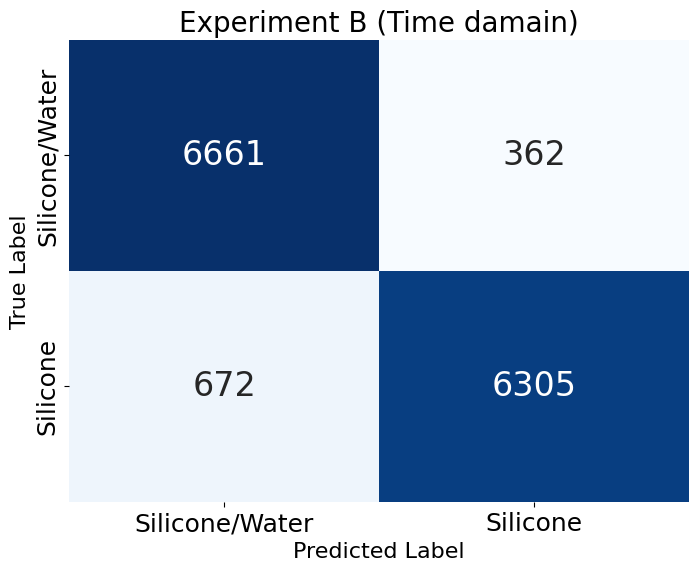

In [136]:
print(f'Accuracy: {r_accuracy}')
plt.figure(figsize=(8,6))
sns.heatmap(
    r_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=realmater,
    yticklabels=realmater,
    annot_kws={"size": 24}  # 设置数字字体大小
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Experiment B (Time damain)")
plt.xticks()
plt.yticks()
# plt.savefig("/Users/stonyxiong/files/Research/figures/ExpB-time.pdf", format="pdf", bbox_inches="tight")
plt.show()
